In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

%matplotlib inline

In [2]:
# Load data and display basic info.
pd.set_option('display.max_columns', 40)
df = pd.read_csv("../DATA/league_games.csv")
display(df.head(5), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16272 entries, 0 to 16271
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   blue.win               16272 non-null  int64  
 1   blue.firstBlood        16272 non-null  int64  
 2   blue.firstTower        16272 non-null  int64  
 3   blue.firstInhibitor    16272 non-null  int64  
 4   blue.firstBaron        16272 non-null  int64  
 5   blue.firstDragon       16272 non-null  int64  
 6   blue.firstRiftHerald   16272 non-null  int64  
 7   blue.towerKills        16272 non-null  int64  
 8   blue.inhibitorKills    16272 non-null  int64  
 9   blue.baronKills        16272 non-null  int64  
 10  blue.dragonKills       16272 non-null  int64  
 11  blue.riftHeraldKills   16272 non-null  int64  
 12  red.win                16272 non-null  int64  
 13  red.firstBlood         16272 non-null  int64  
 14  red.firstTower         16272 non-null  int64  
 15  re

,blue.win,blue.firstBlood,blue.firstTower,blue.firstInhibitor,blue.firstBaron,blue.firstDragon,blue.firstRiftHerald,blue.towerKills,blue.inhibitorKills,blue.baronKills,blue.dragonKills,blue.riftHeraldKills,red.win,red.firstBlood,red.firstTower,red.firstInhibitor,red.firstBaron,red.firstDragon,red.firstRiftHerald,red.towerKills,red.inhibitorKills,red.baronKills,red.dragonKills,red.riftHeraldKills,blue.kills,red.kills,blue.deaths,red.deaths,blue.assists,red.assists,blue.visionScore,red.visionScore,blue.csPerMin,red.csPerMin,blue.goldPerMin,red.goldPerMin,blue.crowdControlTime,red.crowdControlTime
0,1,0,1,0,0,1,1,5,0,0,3,2,0,1,0,0,0,0,0,1,0,0,1,0,25,12,12,25,39,14,174,136,23.4,25.7,1408.5,1322.2,80,108
1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,3,0,0,2,1,11,22,22,11,14,25,69,55,21.6,24.0,1312.5,1589.5,60,37
2,1,1,1,0,0,1,1,6,0,0,2,1,0,0,0,0,0,0,0,1,0,0,1,0,30,8,8,30,46,11,113,93,22.8,21.4,1553.5,1210.6,84,82
3,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,5,0,0,2,1,6,24,24,6,4,34,98,93,21.6,25.1,1134.4,1590.4,48,87
4,0,0,0,0,0,0,0,2,0,1,1,0,1,1,1,1,1,1,1,10,4,1,4,2,48,50,50,48,87,84,245,210,16.5,20.3,1596.0,1579.7,127,178


None

In [6]:
def corr_heatmap(df, digits=3, cmap='coolwarm'):
    """
    Creates a correlation heatmap to easily visualize multicollinearity
    that might be present in the dataframe.

    Parameters
    ----------
    df : DataFrame
        Dataset to check correlation heatmap.
        
    digits : int
        Number of decimal places to display
    
    cmap : str
        Colormap to display correlation range. Preferably divergent colormap
        see https://matplotlib.org/stable/tutorials/colors/colormaps.html#diverging.
        df (DataFrame) : DataFrame with features to check multicollinearity on.

    Returns
    -------
    fig : Matplotlib Figure
    
    ax : Matplotlib Axis
    """
    # Create correlation matrix from dataframe
    correl = df.corr().round(digits)
    correl

    # Create mask for upper triangle of matrix
    mask = np.zeros_like(correl)
    mask[np.triu_indices_from(mask)] = True

    #Create heatmap correlation matrix
    fig, ax = plt.subplots(figsize=((len(df.columns)),(len(df.columns))))
    sns.heatmap(correl, annot=True, ax=ax, cmap=cmap, vmin=-1, vmax=1,\
                mask=mask);
    return fig, ax

(<Figure size 2736x2736 with 2 Axes>, <AxesSubplot:>)

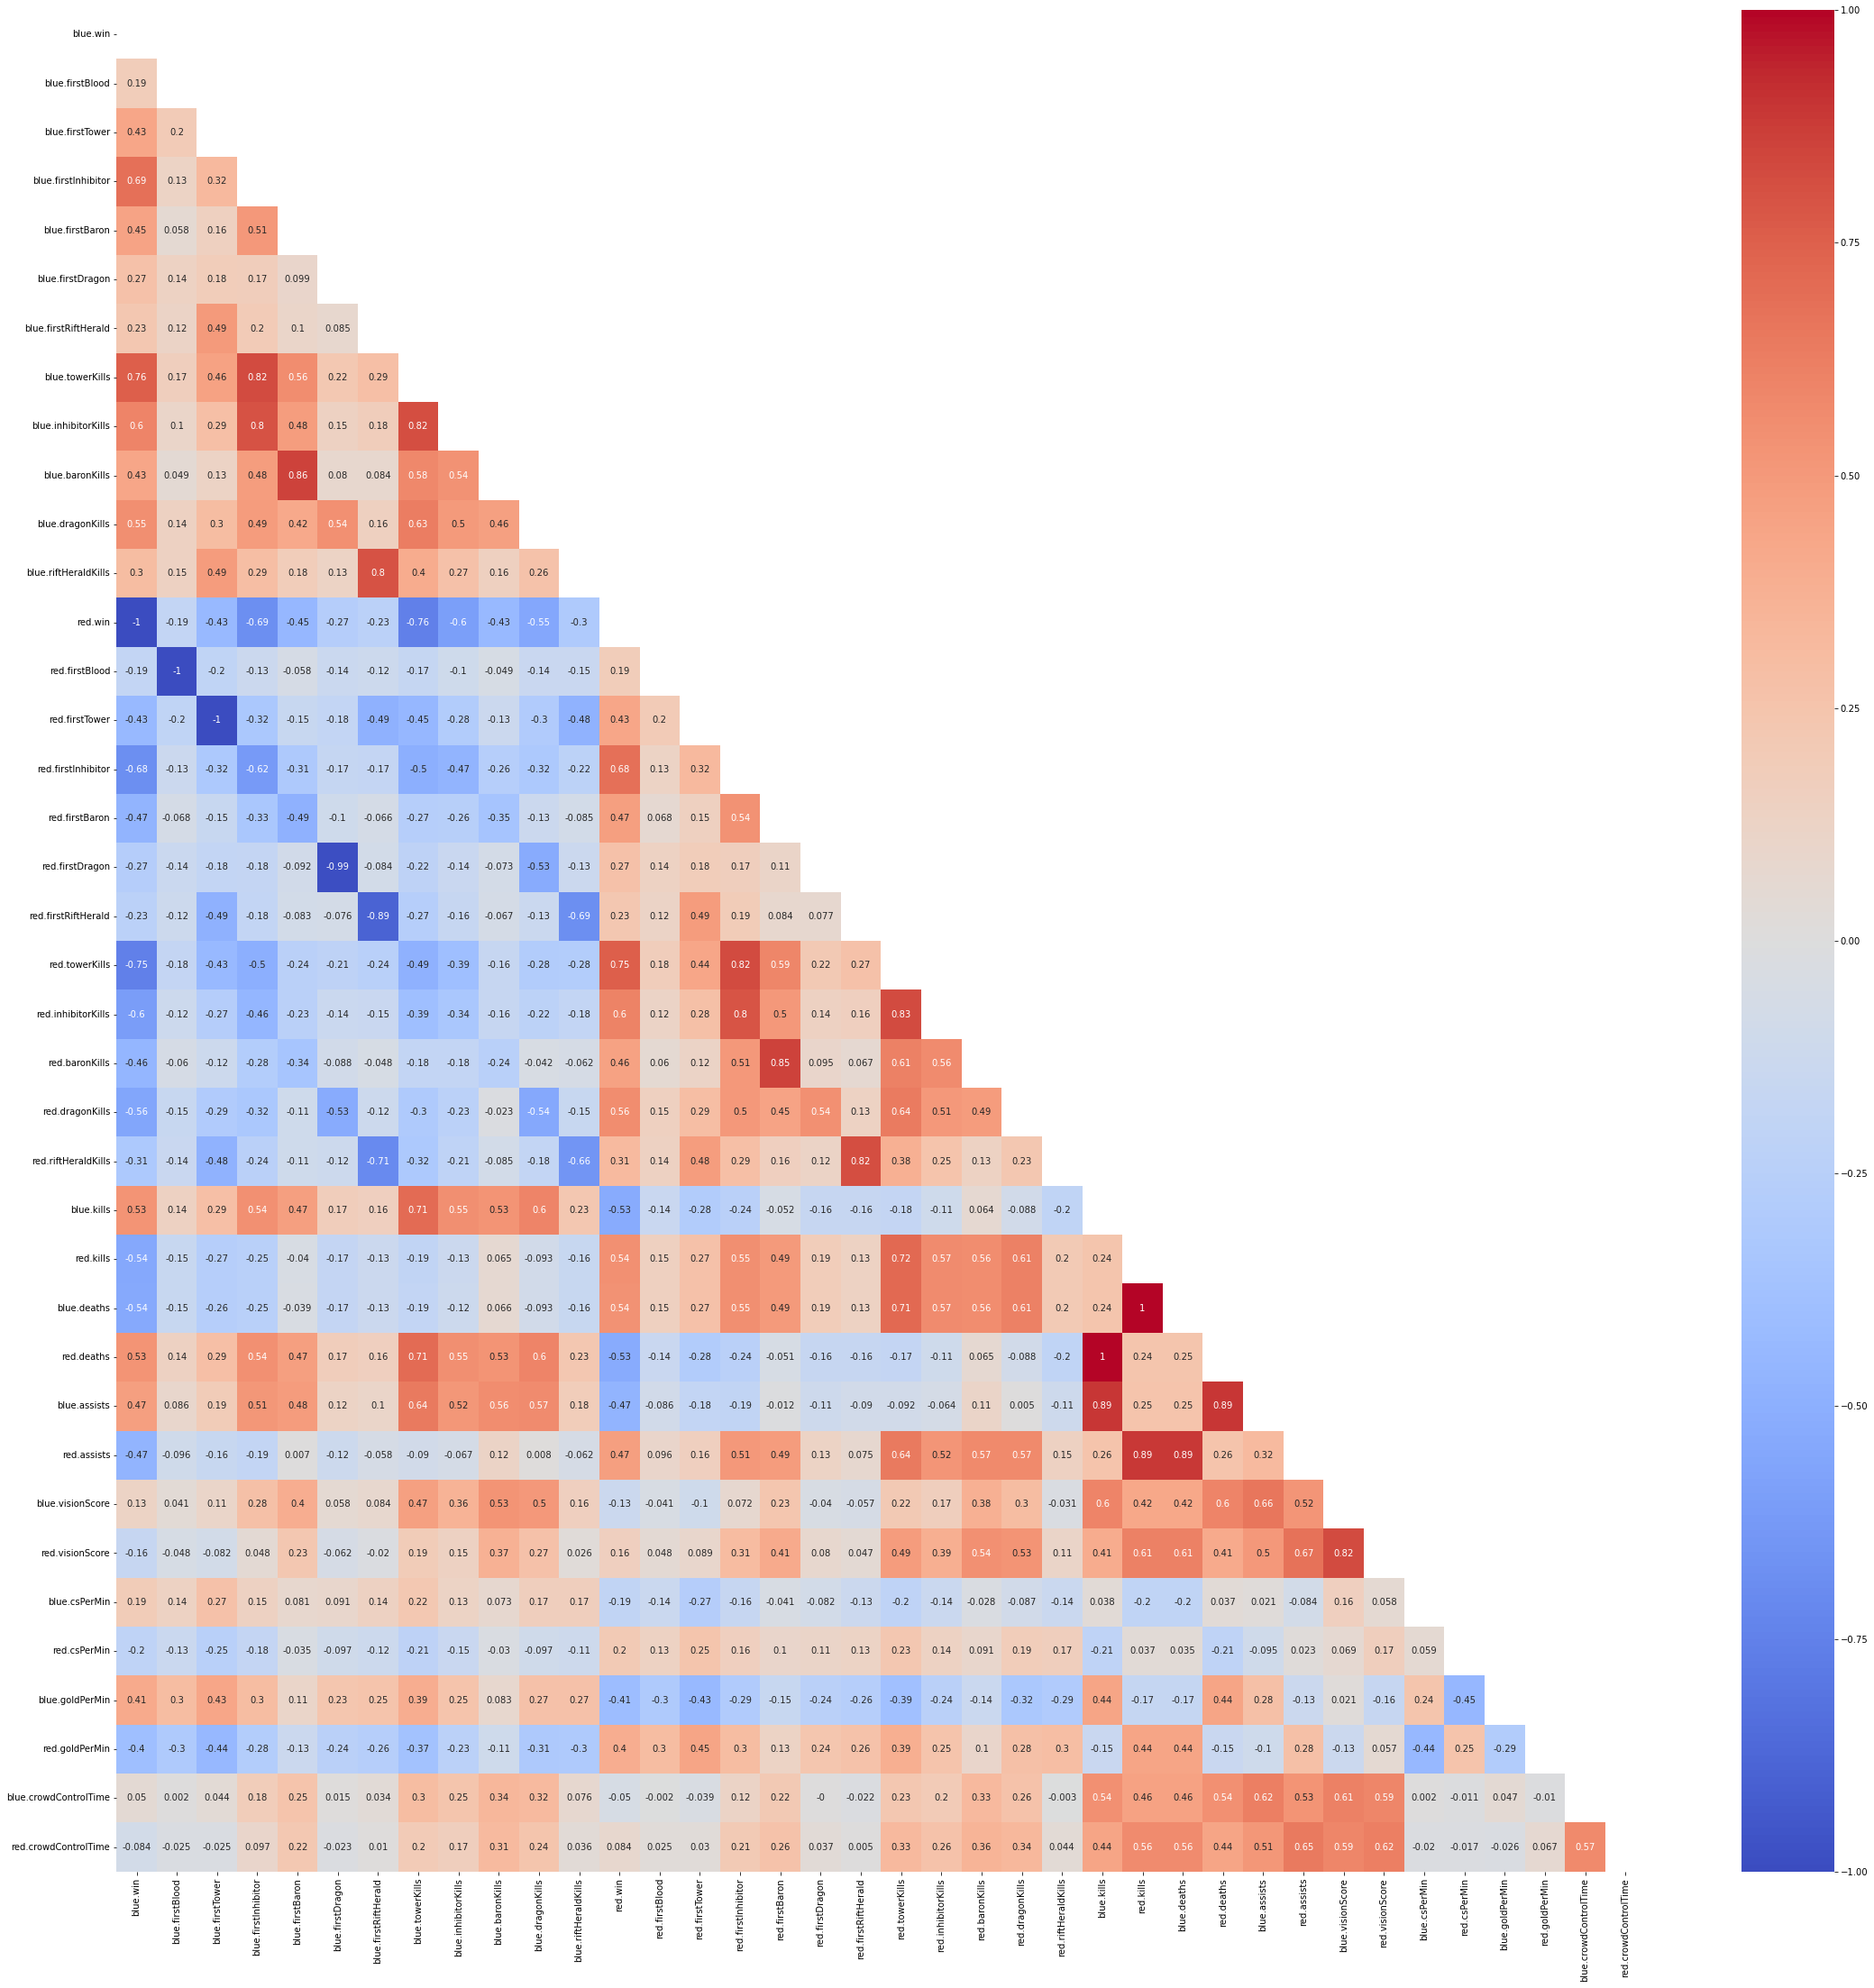

In [7]:
corr_heatmap(df)

A partir da matriz de correlações, ou com um pouco de intuição, podemos observar que muitas features são redundantes (nesse caso, complementares). Tome como exemplo as features `blue.firstTower` e `red.firstTower`. É óbvio que se a equipe azul destruiu a primeira torre, a equipe vermelha não terá destruído. Essa relação vale para algumas outras features em nosso dados. Outro tipo de relação presente nesses dados é entre o KDA (Kill-Death-Assists) das duas equipes. O número de abates de uma equipe claramente reflete o número de mortes da outra.

Podemos evitar essas correlações/redundâncias removendo algumas features do conjunto de dados. Fazendo isso, garantimos um modelo mais claro e adequado para as futuras análises. Detalhes sobre o novo conjunto de dados está listado abaixo.

**OBS**: faremos a modelagem para prever o resultado da partida para a equipe azul (escolhido de forma arbitrária).

In [8]:
# Create df to remove features.
df_reduced = df.copy()

In [9]:
columns_to_drop = [
    # Redundant features
    'red.win', 'red.firstBlood', 'red.firstTower', 'red.firstInhibitor',
    'red.firstBaron', 'red.firstDragon', 'red.firstRiftHerald',
    'red.kills', 'red.deaths'
]
df_reduced.drop(columns_to_drop, axis=1, inplace=True)
df_reduced.columns

Index(['blue.win', 'blue.firstBlood', 'blue.firstTower', 'blue.firstInhibitor',
       'blue.firstBaron', 'blue.firstDragon', 'blue.firstRiftHerald',
       'blue.towerKills', 'blue.inhibitorKills', 'blue.baronKills',
       'blue.dragonKills', 'blue.riftHeraldKills', 'red.towerKills',
       'red.inhibitorKills', 'red.baronKills', 'red.dragonKills',
       'red.riftHeraldKills', 'blue.kills', 'blue.deaths', 'blue.assists',
       'red.assists', 'blue.visionScore', 'red.visionScore', 'blue.csPerMin',
       'red.csPerMin', 'blue.goldPerMin', 'red.goldPerMin',
       'blue.crowdControlTime', 'red.crowdControlTime'],
      dtype='object')

(<Figure size 2088x2088 with 2 Axes>, <AxesSubplot:>)

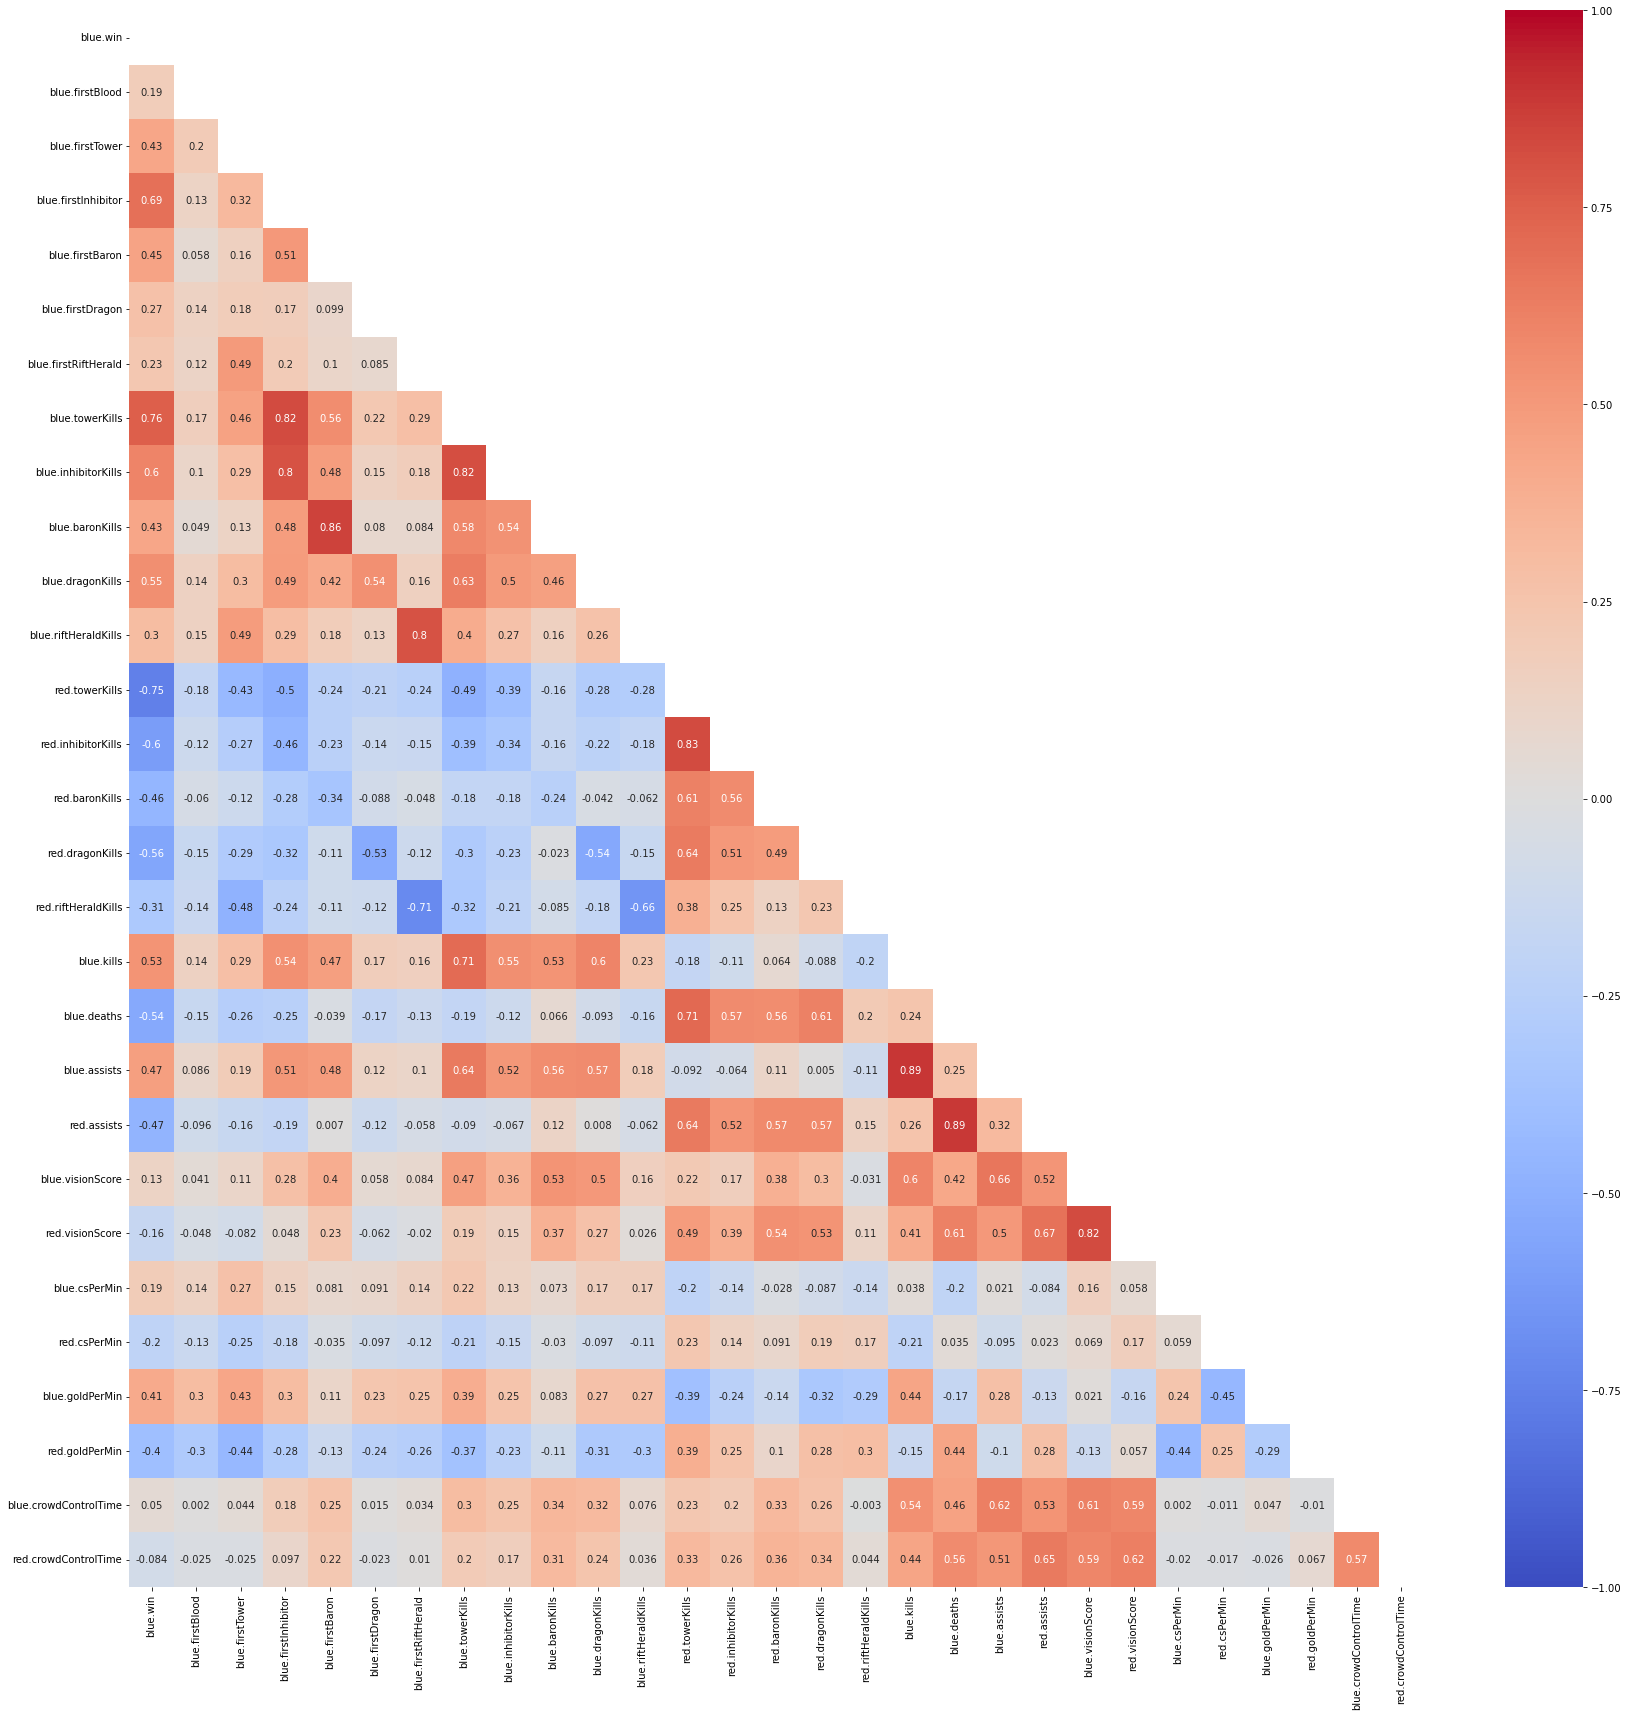

In [10]:
corr_heatmap(df_reduced)

Por que mantivemos algumas features com um grau considerável de correlação?
- `*.visionScore`: é uma medida que quantifica o grau de influência na visão para cada player (nesse caso, temos a soma de todos os players de cada equipe). Pela forma que é definida (ver https://leagueoflegends.fandom.com/wiki/Vision_score), há uma depedência entre as equipes. Ainda assim, mantê-la para as duas equipes pode ser interessante.
- `*.assists`: possuí relação com o número de abates. No entanto, o impacto das assistências é relevante para a análise final.
- As outras features mantiveram correlações abaixo, em módulo, de 0.8. Não sendo um valor tão alto, decidimos mantê-las.